# Comparing SARIMA vs Prophet

Load pre-saved models, evaluate, plot graphs

## Define helper functions

In [54]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid
import logging
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
import pickle
import matplotlib.image as mpimg

cutoff_train_test = 24

def is_cold(el):
    return (el.month > 10 or el.month < 3)

# add "is cold" and concatenate with another time series, if provided (for external regressors)
def prepare_time_series(df, original_df = None):
    df['is_cold'] = df['ds'].apply(is_cold)
    df['is_not_cold'] = ~df['ds'].apply(is_cold)
    if original_df is not None:
        original_df_restricted = original_df.loc[df.index.min():df.index.max(),:]
        return pd.concat([df, original_df_restricted], axis=1)
        
    return df

def make_df(prof,sarima, df_sales, df_external = None):
    if df_external is not None:
            df = pd.concat([df_sales, df_external], axis=1)
    else:
            df = df_sales
    df['ds'] = df.index
    df['y']=df['Sales']
    df = prepare_time_series(df)
    train_df = df[:-cutoff_train_test]

    future = prof.make_future_dataframe(periods=cutoff_train_test, freq = 'MS')
    future['Date'] = future['ds']
    future.set_index('Date', inplace=True)
    if df_external is not None:
            future = prepare_time_series(future, df[df_external.columns])
    else:
            future = prepare_time_series(future)

    forecast = prof.predict(future)
    forecast['Date'] = forecast['ds']
    forecast.set_index('Date', inplace=True)
    pred = sarima.get_prediction(start=0, end=-1)
    fitted_values = pred.predicted_mean
    ci = pred.conf_int(alpha=0.05)
    ci.columns = ['sarima_lower', 'sarima_upper']

    fc = sarima.get_forecast(steps=cutoff_train_test)
    forecasted_values = fc.predicted_mean
    fcci = fc.conf_int(alpha=0.05)
    fcci.columns = ['sarima_lower', 'sarima_upper']

    ci = pd.concat([ci, fcci])

    forecast['sarima_pred'] = forecasted_values
    forecast['sarima_pred'] = forecast['sarima_pred'].fillna(fitted_values)
    forecast = pd.concat([forecast, ci], axis=1)

    viz_df = train_df.join(forecast[['yhat', 'yhat_lower','yhat_upper','sarima_pred','sarima_lower', 'sarima_upper']], how = 'outer')
    viz_df.loc[:,'y'] = df_sales.loc[:,'Sales']
    viz_df[df_external.columns] = df_external[df_external.columns]
    viz_df.loc[:,'ds'] = df_sales.index
    viz_df = prepare_time_series(viz_df)
    return viz_df

def plot_verif(verif, cutoff, ax, title=None, predcol='yhat',lower='yhat_lower', upper='yhat_upper'):
    train = verif[:-cutoff]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train[predcol], color='steelblue', lw=0.5)
    ax.fill_between(train.index, train[lower], train[upper], color='steelblue', alpha=0.3)
    test = verif[-cutoff-1:]
    ax.plot(test.index, test.y, 'ro', markersize=3)
    ax.plot(test.index, test[predcol], color='coral', lw=0.5)
    ax.fill_between(test.index, test[lower], test[upper], color='coral', alpha=0.3)
    ax.axvline(test.index.min(), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    if title is not None: 
        ax.set_title(title, fontsize=16)


def plot_joint_plot(verif, x='yhat', y='y', title=None,cutoff=cutoff_train_test, xlim=[0, 4e7], ylim=[0, 4e7]): 
    train = verif[:-cutoff]
    test = verif[-cutoff-1:]

    g = sns.jointplot(x=x, y=y, data = verif, kind="reg", color="blue")
    sns.scatterplot(x=x, y=y, data=test, color='red', ax=g.ax_joint)

    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    ax = g.fig.axes[1]
    ax.set_xlim(xlim)

    if title is not None: 
        ax.set_title(title, fontsize=16)
    ax = g.fig.axes[0]
    ax.text(0, 0, "R = {:+4.2f}\nMAE = {:4.1f}".format(verif.loc[:,[y,x]].corr().iloc[0,1], mean_absolute_error(verif.loc[:,y].values, verif.loc[:,x].values)), fontsize=16)
    ax.set_xlabel("model's estimates", fontsize=15)
    ax.set_ylabel("observations", fontsize=15)
    ax.set_ylim(ylim)

    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];
    ax.grid(ls=':')
    return g

def plot_comparative(viz_df):
    f, axes = plt.subplots(2, 2, figsize=(20, 16), gridspec_kw={'width_ratios': [8, 2]})
    prof_residuals = viz_df['Sales'] - viz_df['yhat']
    sarima_residuals = viz_df['Sales'] - viz_df['sarima_pred']

    prof_range = [viz_df['yhat'].min(),viz_df['yhat'].max()]
    data_range = [viz_df['Sales'].min(),viz_df['Sales'].max()]
    sarima_range = [viz_df['sarima_pred'].min(),viz_df['sarima_pred'].max()]
    pred_range = [min(prof_range[0], sarima_range[0]), max(prof_range[1], sarima_range[1])]
    plot_verif(viz_df, cutoff_train_test, axes[0, 0], title="Prophet prediction")
    plot_verif(viz_df, cutoff_train_test, axes[1, 0], title="SARIMA predictions", predcol='sarima_pred', lower='sarima_lower', upper='sarima_upper')
    prof_residuals.hist(bins=7, ax=axes[0,1])
    sarima_residuals.hist(bins=7, ax=axes[1,1])
    axes[0,1].set_title("Prophet residuals")
    axes[1,1].set_title("SARIMA residuals")
    plt.tight_layout()
    jg1 = plot_joint_plot(viz_df, title="Prophet predictions", xlim=pred_range, ylim=data_range)
    jg2 = plot_joint_plot(viz_df, x='sarima_pred', title="SARIMA predictions", xlim=pred_range, ylim=data_range)

    jg1.savefig('jg1.png', dpi=200)
    plt.close(jg1.fig)

    jg2.savefig('jg2.png', dpi=200)
    plt.close(jg2.fig)
    f, axarr = plt.subplots(1, 2, figsize=(14, 10))

    axarr[0].imshow(mpimg.imread('jg1.png'))
    axarr[1].imshow(mpimg.imread('jg2.png'))

    # turn off x and y axis
    [ax.set_axis_off() for ax in axarr.ravel()]
    plt.tight_layout()


## Evaluate total sales

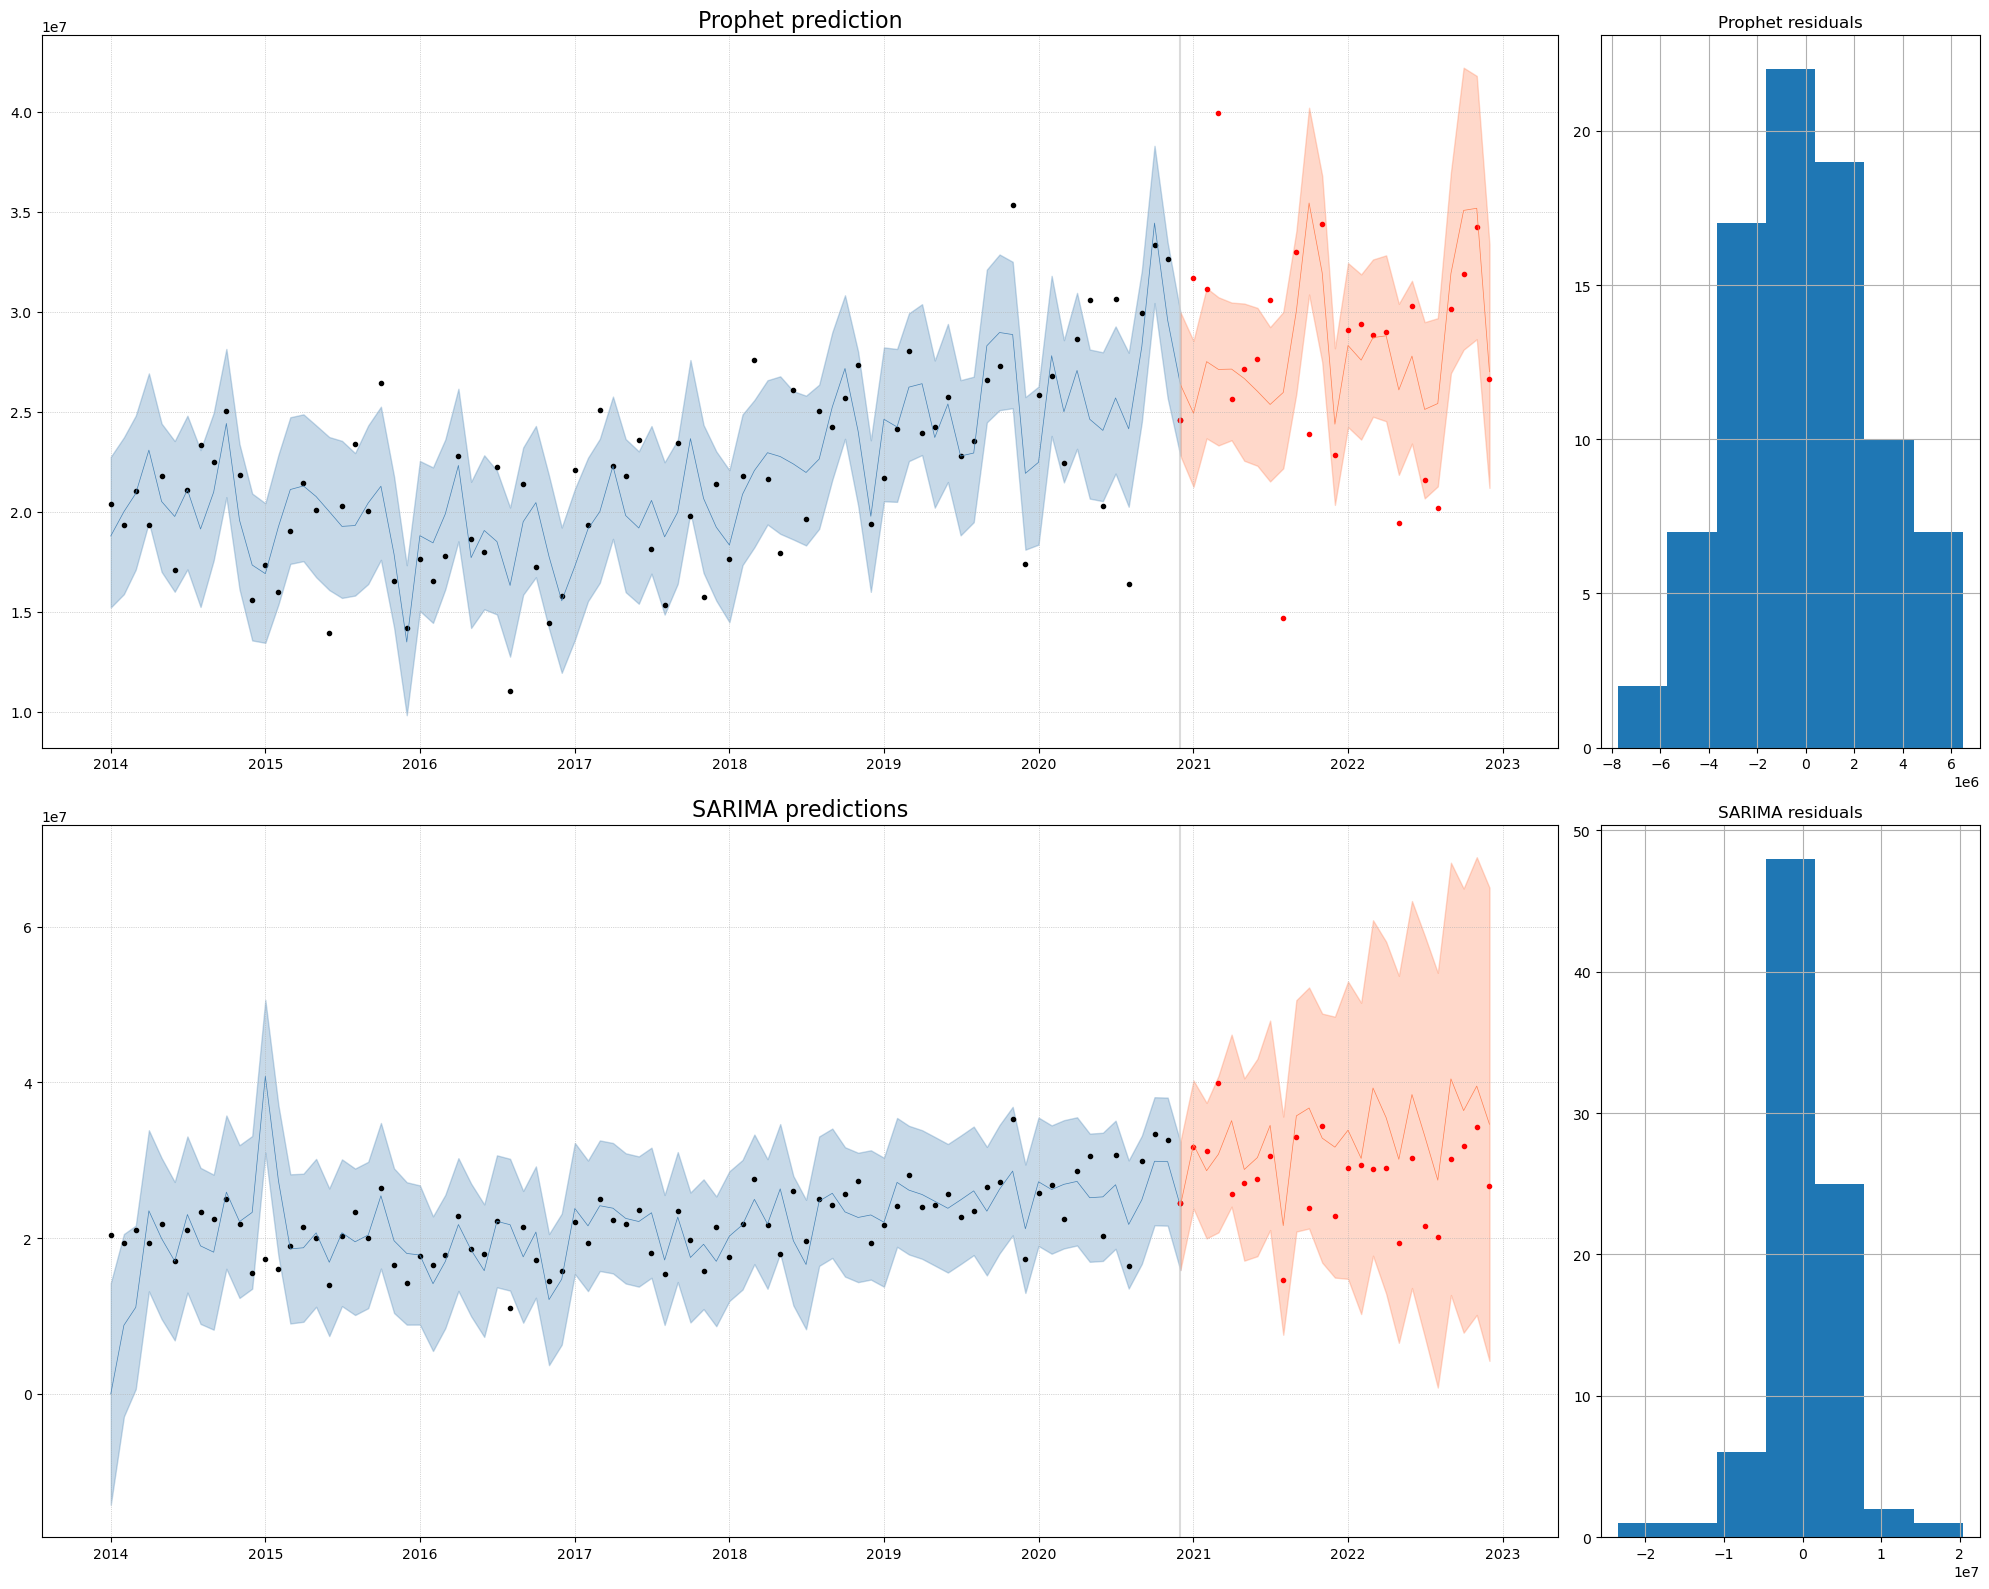

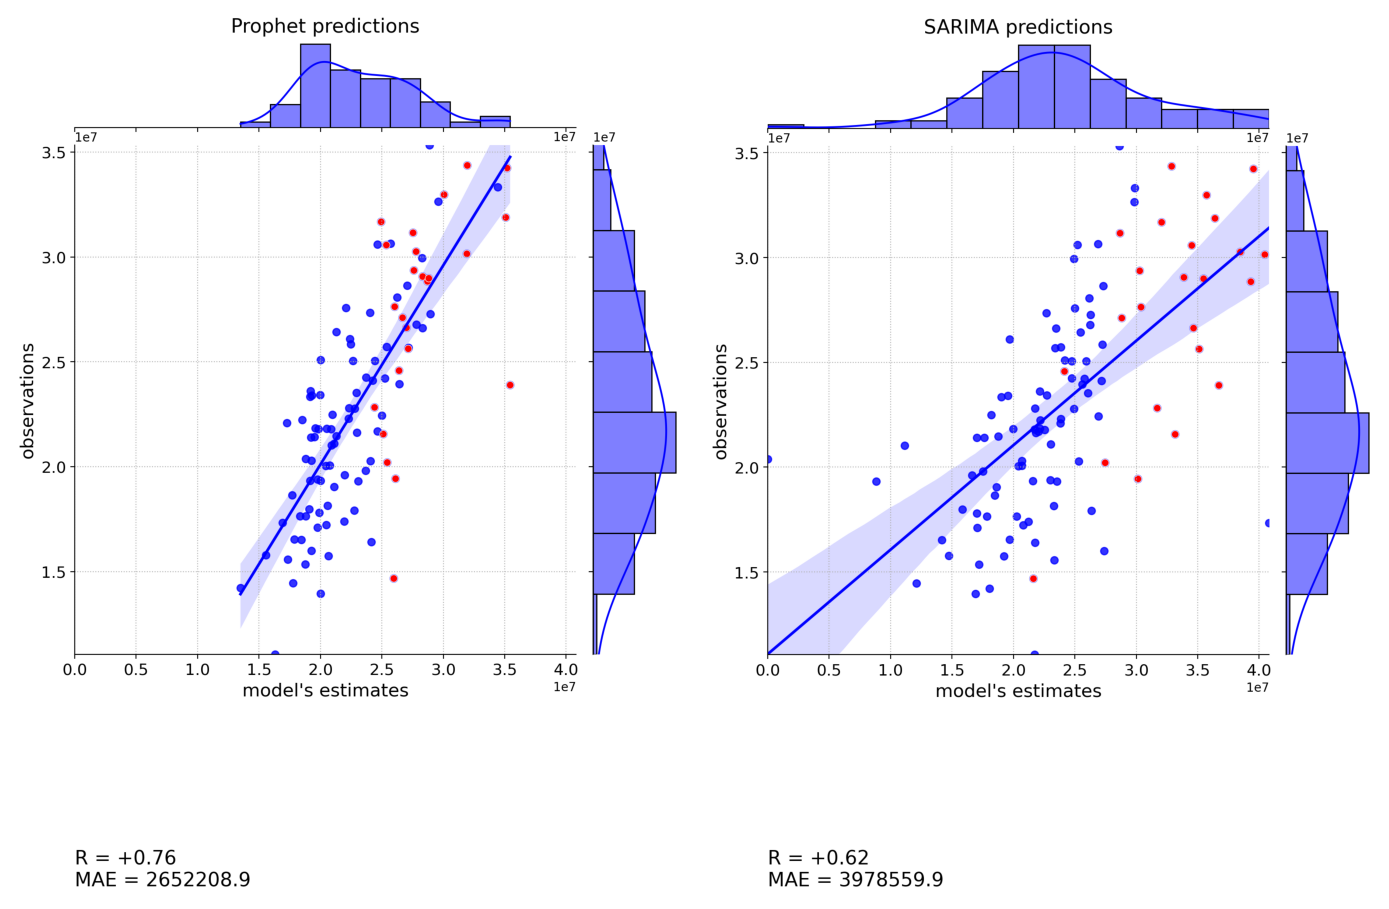

In [55]:
sarima_model = pickle.load(open('sarima.model', 'rb'))
prophet_model = pickle.load(open('prof.model', 'rb'))

df_sales = pd.read_excel("data_full.xlsx", parse_dates=True,usecols = "A,B").set_index('Date')
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')
df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]
viz_df = make_df(prophet_model, sarima_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df)


## Evaluate partial sales (neurology_anestesthesia)

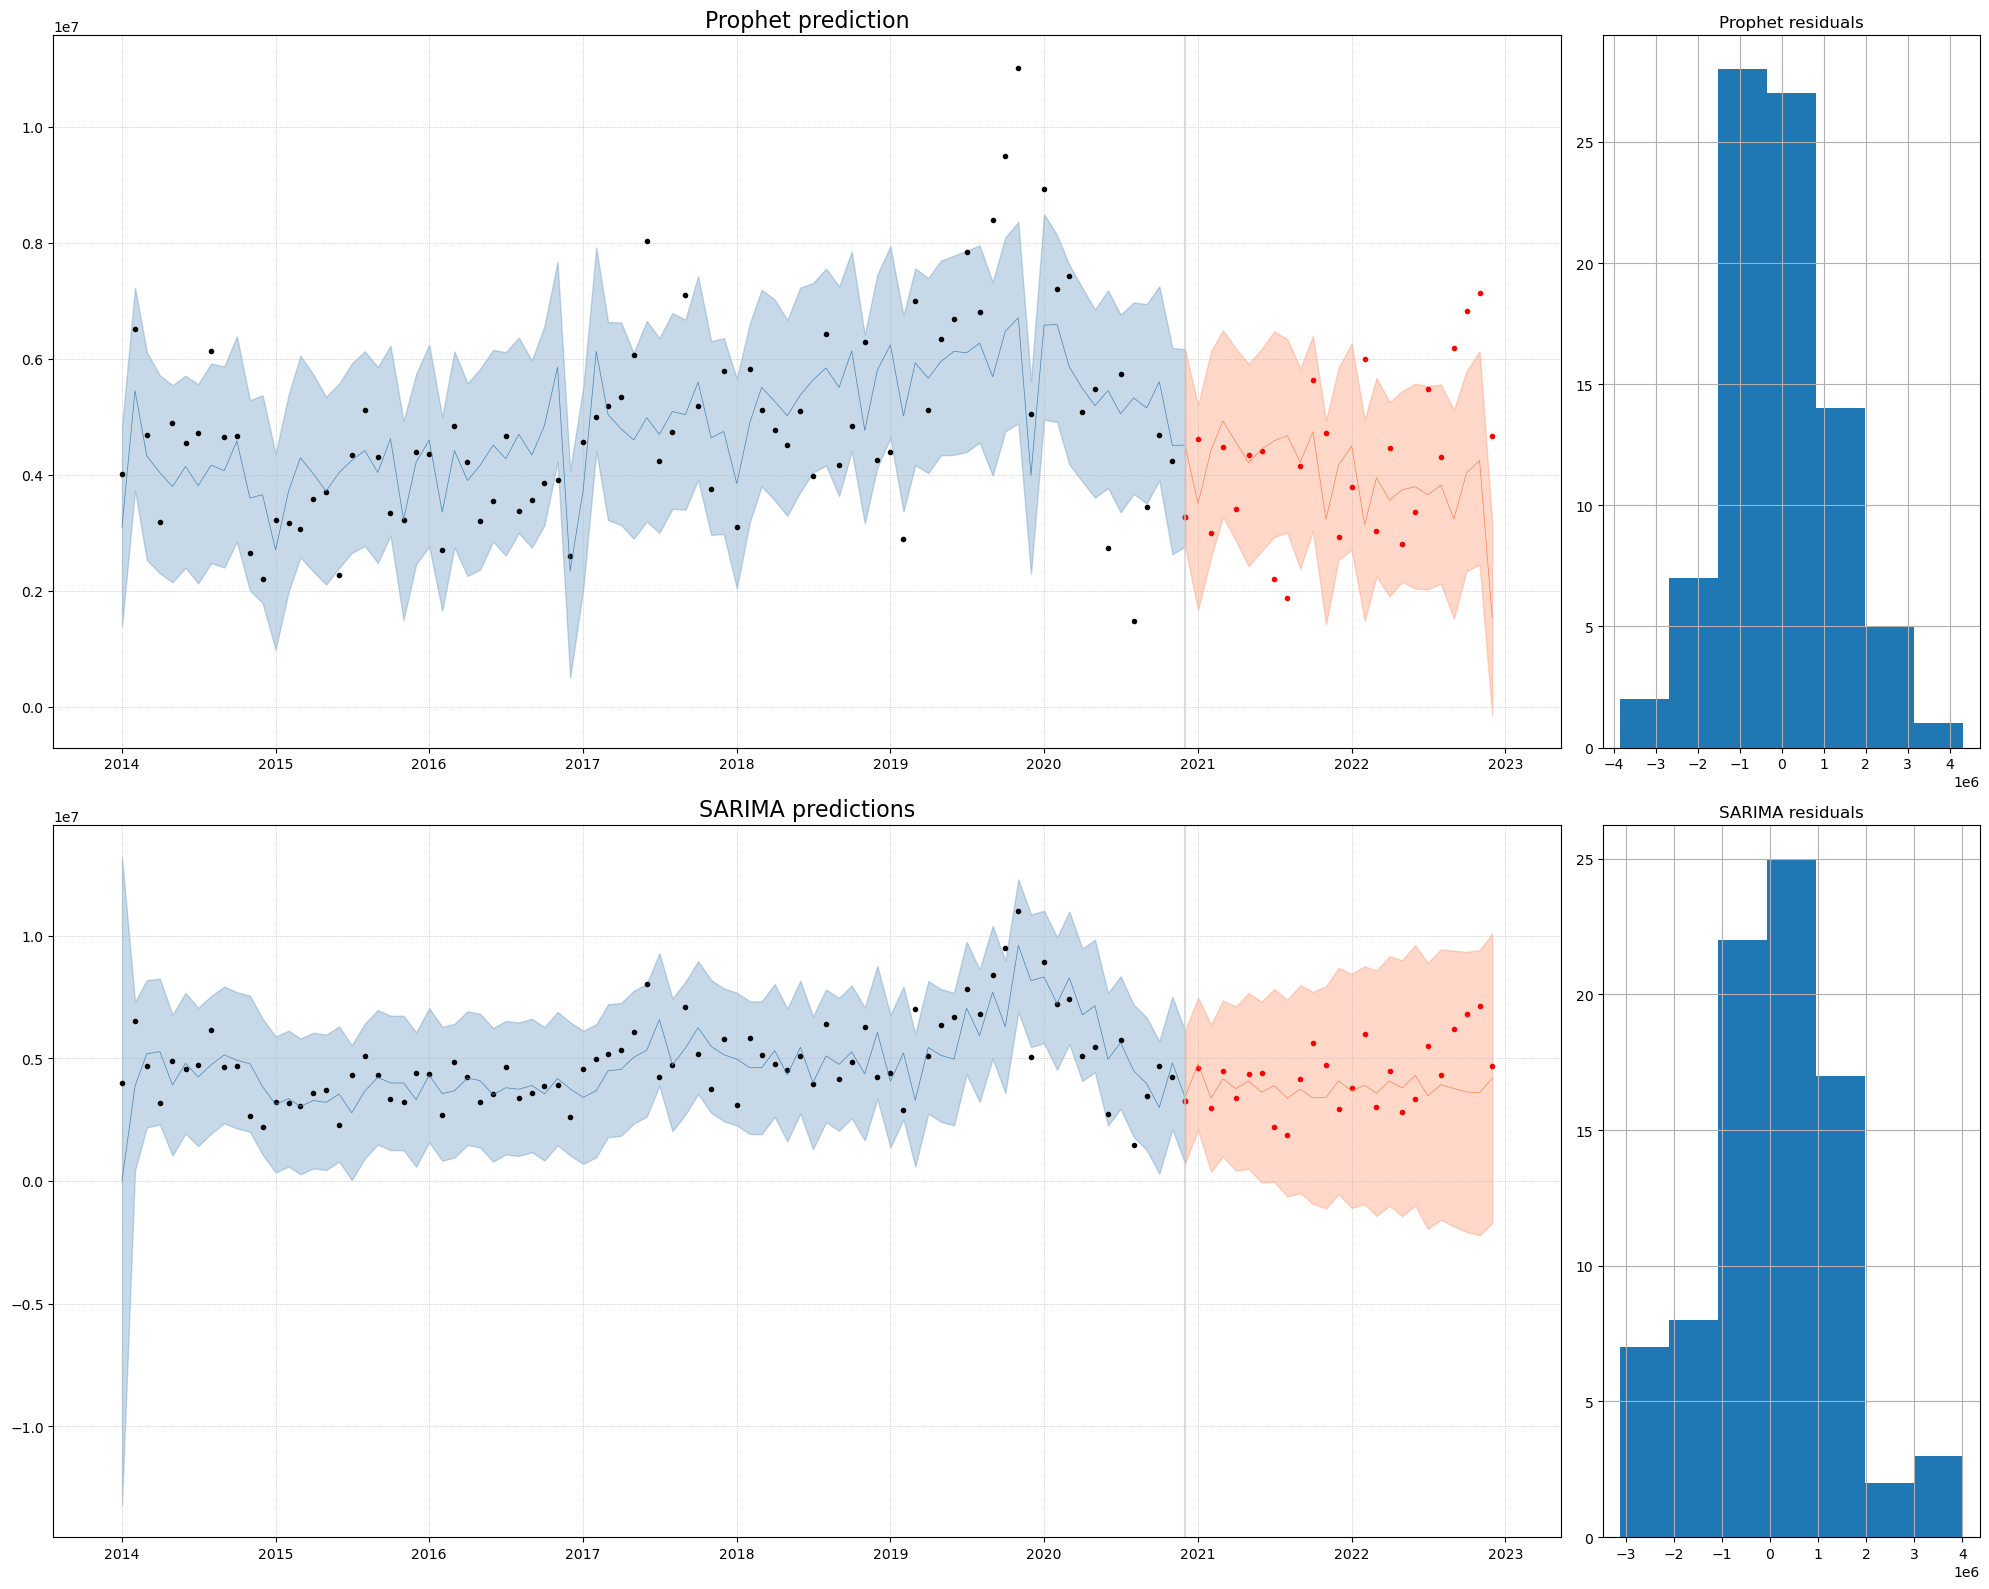

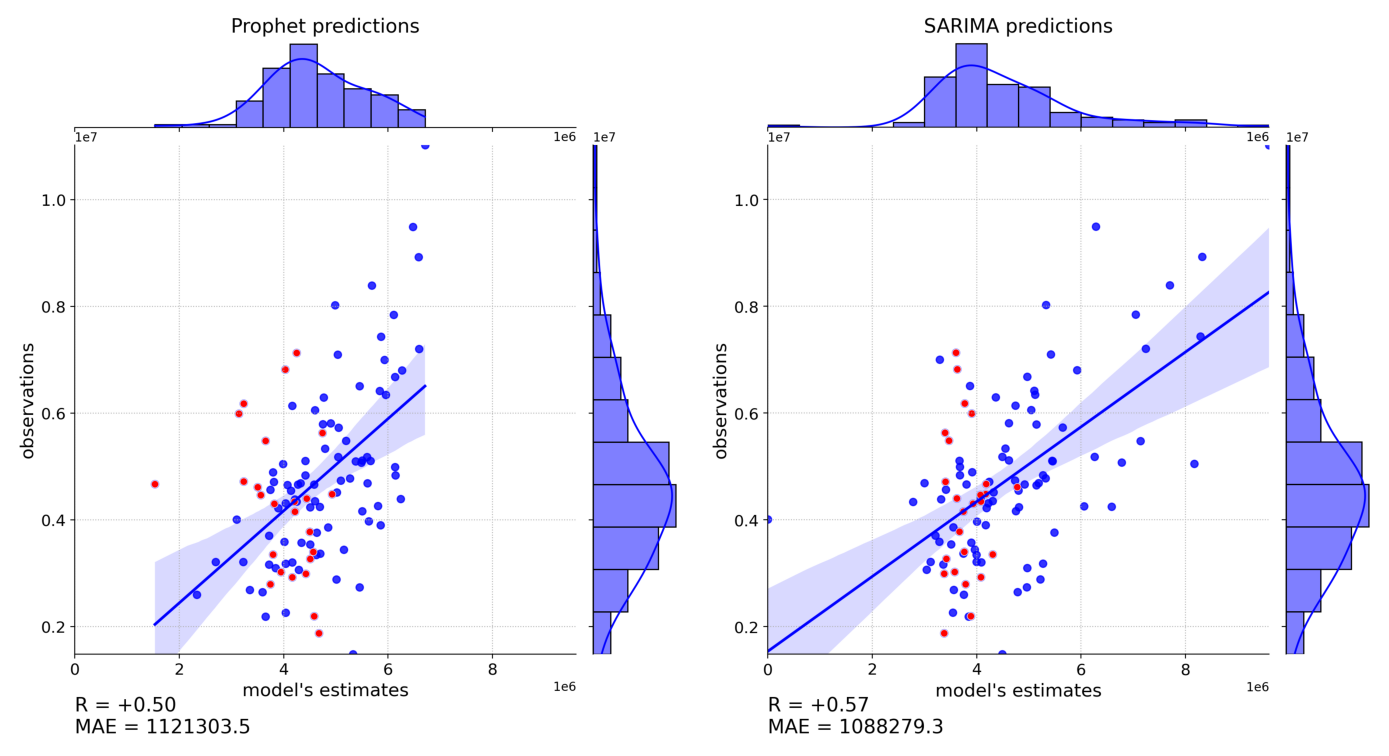

In [53]:
sarima_model = pickle.load(open('sarima_neurology_anestesthesia.model', 'rb'))
prophet_model = pickle.load(open('prof_neurology_anestesthesia.model', 'rb'))

df_sales = pd.read_excel("data_for_clustering.xlsx", parse_dates=True,usecols = "A,F").set_index('Date')
df_sales= df_sales.rename(columns={'neurology_anestesthesia' : 'Sales'})
df_sales.index = pd.to_datetime(df_sales.index)
df_vaccines = pd.read_csv("vaccines.csv", parse_dates=True)

df_vaccines['Date'] = pd.to_datetime(df_vaccines['Date'], format='%Y-%m')

df_vaccines = df_vaccines.set_index('Date')

# restrict additional regressor to same time
df_vaccines = df_vaccines.loc[df_sales.index.min():df_sales.index.max(),:]

viz_df = make_df(prophet_model, sarima_model, df_sales, df_vaccines[['vaccine']])
plot_comparative(viz_df)
